In [ ]:
from google.colab import files
!pip install pdfplumber python-docx spacy
!python -m spacy download en_core_web_sm
import os
import pdfplumber
import docx
import re
import random
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
upload_flag = '/content/data/data'
if not os.path.isdir(upload_flag):
  !unzip Resume.zip
  !unzip job_descriptions_cleaned.csv.zip
else:
  print('File already uploaded')

File already uploaded


The text from the resume pdfs need to be extracted and the extracted text needs to be further cleaned

In [ ]:
def pdf_to_text(path):
    with pdfplumber.open(path) as pdf:
        return ' '.join([page.extract_text() for page in pdf.pages if page.extract_text()])

def docx_to_text(path):
    doc = docx.Document(path)
    return ' '.join([p.text for p in doc.paragraphs])

def read_text_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

The weak verbs and passive voice will be detected through pos tagging and accordingly the function will return the parts of speech with appropriate suggestions.

In [ ]:
weak_verbs = []
with open('Weak_Verbs.txt','r') as file:
  for line in file:
    line = line.strip().lower()
    if line != '':
      weak_verbs.append(line)

def resume_analyser_feedback(resume_doc, weak_verbs=None):
  passive_count = 0
  used_verbs = []
  weak_verbs_found = []
  feedback = []
  passive_verbs_regex = re.compile(r'\b(was|were|is|are|been|being)\s+\w+ed\b')
  for sentence in resume_doc.sents:
    if passive_verbs_regex.search(sentence.text.lower()):
      passive_count = passive_count + 1
    for token in sentence:
      if token.pos_ == "VERB":
        word = token.text.lower()
        used_verbs.append(word)
        if word in weak_verbs:
          if word not in weak_verbs_found:
            weak_verbs_found.append(word)

  if weak_verbs_found:
    feedback.append("Applicant should consider replacing weak verbs like " + ", ".join(f"'{w}'" for w in weak_verbs_found) + " with stronger alternatives")
  else:
    feedback.append("All action words used by the applicant are good")

  return{
      "passive_count": passive_count,
      "verbs": used_verbs,
      "feedback": feedback
  }

The resume is scanned to identify the file type and accordingly the POS tags are generated

In [ ]:
nlp = spacy.load("en_core_web_sm")
resume_details = []
folders = sorted(os.listdir("/content/data/data"))[:24]
extracted_text = ''
base_path = "/content/data/data"
resumes_in_folder = None

for folder in folders:
  folder_path = os.path.join(base_path,folder)
  resumes_in_folder = [f for f in os.listdir(folder_path) if f.lower().endswith(('.pdf', '.docx', '.txt'))]
  print (resumes_in_folder)
  if not resumes_in_folder:
      continue

  selected_file = random.choice(resumes_in_folder)
  full_file_path = os.path.join(folder_path, selected_file)
  file_extension = os.path.splitext(selected_file)[1].lower().strip()

  if file_extension == ".pdf":
    extracted_text = pdf_to_text(full_file_path)
  elif file_extension == ".docx":
    extracted_text = docx_to_text(full_file_path)
  elif file_extension == ".txt":
    extracted_text = read_text_file(full_file_path)
  else:
    print('Unsupported file type. Please upload PDF, DOCX, or TXT.')

  cleaned_text = clean_text(extracted_text)
  user_emails = re.findall(r'\S+@\S+', cleaned_text)
  user_phones = re.findall(r'(\+?\d[\d\-\s]{8,}\d)', cleaned_text)
  document = nlp(cleaned_text)
  analysis = resume_analyser_feedback(document,weak_verbs)
  passive_count = analysis['passive_count']
  verbs = analysis['verbs']
  feedback = analysis['feedback']
  resume_details.append({
      "filename": selected_file,
      "domain": folder,
      "final_text": cleaned_text,
      "pos_tags": [(t.text, t.pos_) for t in document],
      "passive_count": passive_count,
      "verbs" : verbs,
      "feedback": feedback
    })

['24703009.pdf', '33527446.pdf', '21853199.pdf', '14126433.pdf', '25862026.pdf', '21794875.pdf', '21338490.pdf', '20253563.pdf', '23246831.pdf', '23387174.pdf', '27980446.pdf', '25749150.pdf', '36024962.pdf', '78257294.pdf', '23139819.pdf', '13491889.pdf', '30304575.pdf', '80053367.pdf', '15821633.pdf', '49204385.pdf', '16237710.pdf', '37370455.pdf', '78403342.pdf', '25462793.pdf', '14496667.pdf', '53640713.pdf', '30361788.pdf', '29999135.pdf', '20082776.pdf', '10674770.pdf', '15289348.pdf', '62809577.pdf', '36425270.pdf', '25127518.pdf', '14055988.pdf', '38847011.pdf', '26065877.pdf', '34198885.pdf', '18365791.pdf', '21763056.pdf', '17556527.pdf', '23416654.pdf', '12202337.pdf', '28969385.pdf', '23438112.pdf', '87635012.pdf', '20393721.pdf', '30813919.pdf', '14224370.pdf', '98559931.pdf', '28614791.pdf', '28359817.pdf', '17407184.pdf', '14491649.pdf', '24799301.pdf', '20345168.pdf', '28298773.pdf', '39115899.pdf', '42487883.pdf', '26975573.pdf', '27637576.pdf', '19545827.pdf', '258678

['74126637.pdf', '14146106.pdf', '38059130.pdf', '78538268.pdf', '32965335.pdf', '40088790.pdf', '77439230.pdf', '35474904.pdf', '20272792.pdf', '97405769.pdf', '89508407.pdf', '26071861.pdf', '20138606.pdf', '17254634.pdf', '22042181.pdf', '17911230.pdf', '18997135.pdf', '24754689.pdf', '49486820.pdf', '38860712.pdf', '13967854.pdf', '93512385.pdf', '54067174.pdf', '23804341.pdf', '31040875.pdf', '11188218.pdf', '17021141.pdf', '53169257.pdf', '74191424.pdf', '73448369.pdf', '13593241.pdf', '36392131.pdf', '28974459.pdf', '34327438.pdf', '20324037.pdf', '46772262.pdf', '23577836.pdf', '72652441.pdf', '19926135.pdf', '11773767.pdf', '28635795.pdf', '47133747.pdf', '27182111.pdf', '28871170.pdf', '13342150.pdf', '11174187.pdf', '34970271.pdf', '91051945.pdf', '38698573.pdf', '20604208.pdf', '95970987.pdf', '13115648.pdf', '15958967.pdf', '13909762.pdf', '75435017.pdf', '37333719.pdf', '29415426.pdf', '10344379.pdf', '19518606.pdf', '14445309.pdf', '10818478.pdf', '14064815.pdf', '244104

['37292350.pdf', '26921245.pdf', '30437583.pdf', '24068423.pdf', '17640785.pdf', '36102323.pdf', '62994611.pdf', '24001783.pdf', '23631188.pdf', '16507693.pdf', '19532392.pdf', '29510501.pdf', '29142288.pdf', '21868149.pdf', '29746235.pdf', '29897742.pdf', '55712978.pdf', '16849128.pdf', '14140903.pdf', '21134923.pdf', '26835781.pdf', '11813872.pdf', '11197262.pdf', '20969119.pdf', '28733974.pdf', '11676151.pdf', '28165687.pdf', '81042872.pdf', '15546686.pdf', '34141299.pdf', '89740812.pdf', '16661264.pdf', '28247753.pdf', '12674256.pdf', '19851252.pdf', '18242317.pdf', '15053703.pdf', '27888251.pdf', '17312146.pdf', '84512719.pdf', '26070334.pdf', '69360287.pdf', '27689009.pdf', '69859102.pdf', '55500538.pdf', '24397882.pdf', '16172429.pdf', '24416961.pdf', '38216888.pdf', '40882926.pdf', '69336473.pdf', '37201447.pdf', '17499196.pdf', '18264694.pdf', '16653657.pdf', '54246169.pdf', '10953078.pdf', '56068028.pdf', '12341902.pdf', '20006992.pdf', '29968330.pdf', '79536879.pdf', '156033

['50324968.pdf', '21807211.pdf', '24516163.pdf', '10738095.pdf', '71499299.pdf', '17659053.pdf', '35121930.pdf', '35603950.pdf', '27694040.pdf', '26829561.pdf', '12059610.pdf', '13418452.pdf', '11677077.pdf', '14698557.pdf', '31761591.pdf', '83566455.pdf', '27549075.pdf', '16915389.pdf', '26098594.pdf', '72807293.pdf', '15535408.pdf', '78273826.pdf', '10876132.pdf', '36094883.pdf', '29521434.pdf', '25543217.pdf', '14304010.pdf', '17714174.pdf', '16391949.pdf', '10562768.pdf', '58208591.pdf', '26586477.pdf', '43852883.pdf', '46514339.pdf', '21007083.pdf', '16605640.pdf', '20905088.pdf', '33665485.pdf', '21570485.pdf', '15154822.pdf', '29764492.pdf', '14413257.pdf', '19402977.pdf', '71767359.pdf', '19714635.pdf', '91026230.pdf', '13858219.pdf', '24989856.pdf', '27176039.pdf', '54308684.pdf', '41586420.pdf', '22852364.pdf', '31225895.pdf', '52252936.pdf', '26691587.pdf', '27091280.pdf', '11409460.pdf', '37750854.pdf', '16985289.pdf', '36136569.pdf', '28998957.pdf', '16723524.pdf', '128605

['14150896.pdf', '17033567.pdf', '37472265.pdf', '16244633.pdf', '11555549.pdf', '20488267.pdf', '12777487.pdf', '65352424.pdf', '31114531.pdf', '12413512.pdf', '39470264.pdf', '14879257.pdf', '21060367.pdf', '32318506.pdf', '19724031.pdf', '22182279.pdf', '37220856.pdf', '28471099.pdf', '20698469.pdf', '43622023.pdf', '53227466.pdf', '16962067.pdf', '11995013.pdf', '18106533.pdf', '22848179.pdf', '36019469.pdf', '30594821.pdf', '26410763.pdf', '32794700.pdf', '25157655.pdf', '24349611.pdf', '20356750.pdf', '39064638.pdf', '17694454.pdf', '12334650.pdf', '18029935.pdf', '28325193.pdf', '36758947.pdf', '31273413.pdf', '23752500.pdf', '15265464.pdf', '99561379.pdf', '83338413.pdf', '29148871.pdf', '15306049.pdf', '28629430.pdf', '12386670.pdf', '83206166.pdf', '73497035.pdf', '24061629.pdf', '20149476.pdf', '39608848.pdf', '17857644.pdf', '27715131.pdf', '79432080.pdf', '78107631.pdf', '34304175.pdf', '22593054.pdf', '66226673.pdf', '34146825.pdf', '46055835.pdf', '41950126.pdf', '239178

['17571262.pdf', '97449528.pdf', '28790806.pdf', '23009962.pdf', '25047127.pdf', '11152490.pdf', '17510973.pdf', '18932512.pdf', '22946204.pdf', '22732234.pdf', '22452756.pdf', '32109048.pdf', '78357954.pdf', '11257723.pdf', '99680385.pdf', '15100547.pdf', '32069695.pdf', '51508889.pdf', '63989974.pdf', '18448085.pdf', '23522150.pdf', '82140102.pdf', '26341645.pdf', '14508237.pdf', '15484011.pdf', '15790602.pdf', '11797122.pdf', '24703983.pdf', '84295343.pdf', '16332293.pdf', '47487091.pdf', '91515108.pdf', '24592627.pdf', '11887930.pdf', '14455622.pdf', '15210069.pdf']


['58048626.pdf', '10567764.pdf', '17876954.pdf', '81588968.pdf', '17694572.pdf', '42427521.pdf', '82738323.pdf', '43720116.pdf', '19818707.pdf', '23761385.pdf', '65219288.pdf', '36252245.pdf', '26888302.pdf', '36727173.pdf', '31605080.pdf', '67631413.pdf', '38989376.pdf', '32720816.pdf', '14589288.pdf', '28020046.pdf', '19506295.pdf', '27902692.pdf', '10176815.pdf', '28186635.pdf', '42641525.pdf', '31536294.pdf', '68216398.pdf', '16279537.pdf', '90318913.pdf', '24589765.pdf', '29221006.pdf', '22442947.pdf', '29595906.pdf', '42546558.pdf', '17152392.pdf', '24773845.pdf', '33627938.pdf', '27502951.pdf', '25719936.pdf', '13234267.pdf', '11614114.pdf', '38355831.pdf', '70198580.pdf', '29534737.pdf', '61315605.pdf', '99416532.pdf', '29161565.pdf', '22168194.pdf', '92283635.pdf', '26819872.pdf', '49646155.pdf', '23464505.pdf', '11959428.pdf', '77626587.pdf', '12504278.pdf', '96457008.pdf', '17983430.pdf', '17655479.pdf', '23985183.pdf', '10189110.pdf', '17483843.pdf', '12904972.pdf', '156848

['18457785.pdf', '89049979.pdf', '65864767.pdf', '32980197.pdf', '73157997.pdf', '29093426.pdf', '38897568.pdf', '35492909.pdf', '33135102.pdf', '18805506.pdf', '43375498.pdf', '18824120.pdf', '45167858.pdf', '28989677.pdf', '17823436.pdf', '21645690.pdf', '41651672.pdf', '19911786.pdf', '28419927.pdf', '19176318.pdf', '60182829.pdf', '96493528.pdf', '20992320.pdf', '18645964.pdf', '22615491.pdf', '19374660.pdf', '21796843.pdf', '36905896.pdf', '27884470.pdf', '17276884.pdf', '16407619.pdf', '18172739.pdf', '11266906.pdf', '68781345.pdf', '13393401.pdf', '30127072.pdf', '26673507.pdf', '35483925.pdf', '29839396.pdf', '30713796.pdf', '21856577.pdf', '34953092.pdf', '35564026.pdf', '15553584.pdf', '64589506.pdf', '15856762.pdf', '74552449.pdf', '16300459.pdf', '27120528.pdf', '28051330.pdf', '10329506.pdf', '31710562.pdf', '17213671.pdf', '12021752.pdf', '23323001.pdf', '21756639.pdf', '27606527.pdf', '17396388.pdf', '25080805.pdf', '28895997.pdf', '54421668.pdf', '98348532.pdf', '116722

['13964744.pdf', '18589927.pdf', '69097572.pdf', '31064969.pdf', '23933031.pdf', '16492045.pdf', '26829350.pdf', '79261033.pdf', '63158213.pdf', '30709029.pdf', '15145575.pdf', '38707449.pdf', '95625660.pdf', '19362586.pdf', '11183737.pdf', '15573418.pdf', '57706851.pdf', '41152404.pdf', '24727739.pdf', '45077654.pdf', '89512321.pdf', '27710853.pdf']


['22423839.pdf', '12230301.pdf', '34797369.pdf', '38007664.pdf', '98379112.pdf', '14825300.pdf', '14055971.pdf', '22765255.pdf', '27796199.pdf', '31273310.pdf', '14861855.pdf', '39237915.pdf', '11088337.pdf', '35673335.pdf', '30938994.pdf', '16694152.pdf', '12632728.pdf', '36574147.pdf', '27219200.pdf', '77576845.pdf', '76916835.pdf', '15423153.pdf', '27004930.pdf', '82118447.pdf', '25397102.pdf', '18311419.pdf', '12377803.pdf', '19557384.pdf', '31813535.pdf', '14990354.pdf', '15811992.pdf', '17421910.pdf', '61677751.pdf', '10501991.pdf', '27937592.pdf', '10289113.pdf', '20317319.pdf', '26896699.pdf', '90629382.pdf', '20427934.pdf', '13199813.pdf', '25813953.pdf', '29208172.pdf', '32042584.pdf', '14287992.pdf', '23568641.pdf', '34046031.pdf', '12546838.pdf', '12059198.pdf', '28916894.pdf', '14871762.pdf', '13888506.pdf', '24647386.pdf', '40792022.pdf', '18757174.pdf', '29908929.pdf', '10541358.pdf', '15233524.pdf', '12814706.pdf', '36805025.pdf', '13574264.pdf', '22025574.pdf', '323855

['21511817.pdf', '28176889.pdf', '29784524.pdf', '19007667.pdf', '13411858.pdf', '22349169.pdf', '30128072.pdf', '21904897.pdf', '22561438.pdf', '29449419.pdf', '30826569.pdf', '16924102.pdf', '11209758.pdf', '25953797.pdf', '18825446.pdf', '32605413.pdf', '24221960.pdf', '92985983.pdf', '14569498.pdf', '47603843.pdf', '26189601.pdf', '16804396.pdf', '16248476.pdf', '30337969.pdf', '23185829.pdf', '29072179.pdf', '10001727.pdf', '13212436.pdf', '94047639.pdf', '57262959.pdf', '47317494.pdf', '32518109.pdf', '91268638.pdf', '25452321.pdf', '12254068.pdf', '20321582.pdf', '18480859.pdf', '92122785.pdf', '24673903.pdf', '21334981.pdf', '29211359.pdf', '61322296.pdf', '62555739.pdf', '33964275.pdf', '24709432.pdf', '10653119.pdf', '86551046.pdf', '47729453.pdf', '28424982.pdf', '15261348.pdf', '20817322.pdf', '18036030.pdf', '23032276.pdf', '38309905.pdf', '21101152.pdf', '28230807.pdf', '53265899.pdf', '10588874.pdf', '16855929.pdf', '35157762.pdf', '20033302.pdf', '15354126.pdf', '160668

['78114950.pdf', '12212468.pdf', '61065616.pdf', '12695537.pdf', '25098739.pdf', '10820510.pdf', '39674782.pdf', '15564893.pdf', '29894080.pdf', '21567392.pdf', '27246366.pdf', '17570634.pdf', '12826414.pdf', '34544955.pdf', '22965804.pdf', '17252448.pdf', '25224998.pdf', '21363048.pdf', '39908485.pdf', '17342969.pdf', '28815362.pdf', '10281555.pdf', '16203589.pdf', '22546476.pdf', '22894544.pdf', '51638201.pdf', '28803888.pdf', '16353584.pdf', '69764348.pdf', '32025286.pdf', '11650031.pdf', '63083944.pdf', '19471144.pdf', '18472240.pdf', '35971546.pdf', '27835351.pdf', '56525735.pdf', '28756444.pdf', '24361598.pdf', '33023370.pdf', '24770846.pdf', '23818675.pdf', '16378091.pdf', '88859947.pdf', '39027764.pdf', '29193505.pdf', '27243670.pdf', '12654876.pdf', '20681037.pdf', '10041713.pdf', '27187994.pdf', '25656981.pdf', '25187733.pdf', '14849103.pdf', '90032884.pdf', '30397268.pdf', '26091595.pdf', '12666174.pdf', '10100240.pdf', '21782152.pdf', '24740005.pdf', '16924279.pdf', '149008

['92246939.pdf', '12526702.pdf', '38399177.pdf', '18227306.pdf', '11835339.pdf', '18856440.pdf', '22485475.pdf', '30863060.pdf', '15433732.pdf', '56792999.pdf', '32433431.pdf', '32637306.pdf', '38896303.pdf', '39308779.pdf', '39441617.pdf', '12374933.pdf', '31201660.pdf', '91116867.pdf', '65062795.pdf', '31016926.pdf', '18079050.pdf', '30083884.pdf', '22259768.pdf', '93349646.pdf', '21366189.pdf', '31395742.pdf', '31169070.pdf', '63670997.pdf', '67406885.pdf', '15602094.pdf', '22351830.pdf', '14517953.pdf', '15699744.pdf', '88907739.pdf', '29076405.pdf', '17025292.pdf', '25258040.pdf', '33919379.pdf', '20176584.pdf', '78016758.pdf', '22571461.pdf', '37818861.pdf', '10984392.pdf', '29196643.pdf', '43378989.pdf', '14346702.pdf', '79570655.pdf', '27096471.pdf', '26919036.pdf', '20574232.pdf', '23302948.pdf', '15535920.pdf', '12251115.pdf', '21568833.pdf', '12897903.pdf', '38457612.pdf', '26291616.pdf', '91189201.pdf', '13454871.pdf', '57364820.pdf', '26234972.pdf', '48533663.pdf', '135691

['37664296.pdf', '26676567.pdf', '85101052.pdf', '11919526.pdf', '34349255.pdf', '25061645.pdf', '37263609.pdf', '28663949.pdf', '26496059.pdf', '12674307.pdf', '21283733.pdf', '37058472.pdf', '12547982.pdf', '19164410.pdf', '19195747.pdf', '51681660.pdf', '22496394.pdf', '29524570.pdf', '18460045.pdf', '34317538.pdf', '94417768.pdf', '38744475.pdf', '20986595.pdf', '20390397.pdf', '62312955.pdf', '23951429.pdf', '30965258.pdf', '26046064.pdf', '25949631.pdf', '20748926.pdf', '30968749.pdf', '67645662.pdf', '26942552.pdf', '15471999.pdf', '24285142.pdf', '18795567.pdf', '18979238.pdf', '36269672.pdf', '29147100.pdf', '68240723.pdf', '11155153.pdf', '26503829.pdf', '41506705.pdf', '22675694.pdf', '91153752.pdf', '29865476.pdf', '42384185.pdf', '34511655.pdf', '34051710.pdf', '28326441.pdf', '24583187.pdf', '32532982.pdf', '17555081.pdf', '93301686.pdf', '39776400.pdf', '10466583.pdf', '17199951.pdf', '12415691.pdf', '27529455.pdf', '34657584.pdf', '39252859.pdf', '26622051.pdf', '359908

['34583750.pdf', '18905648.pdf', '14761906.pdf', '20330739.pdf', '17584743.pdf', '16276121.pdf', '17132168.pdf', '19053815.pdf', '27419236.pdf', '14945250.pdf', '29915354.pdf', '70196518.pdf', '59011090.pdf', '15484097.pdf', '91318828.pdf', '22706174.pdf', '30864828.pdf', '80679862.pdf', '25525152.pdf', '23085604.pdf', '19444529.pdf', '16509761.pdf', '23864858.pdf', '18442517.pdf', '29002596.pdf', '21125113.pdf', '33893326.pdf', '23810469.pdf', '11005406.pdf', '26160200.pdf', '16536141.pdf', '31929166.pdf', '20210676.pdf', '58915642.pdf', '94492380.pdf', '13328680.pdf', '25038571.pdf', '24953921.pdf', '56952849.pdf', '28109594.pdf', '31909493.pdf', '10005171.pdf', '18525641.pdf', '18488289.pdf', '14771530.pdf', '28679359.pdf', '30504149.pdf', '42156237.pdf', '50219114.pdf', '25706337.pdf', '31162167.pdf', '20628003.pdf', '34319869.pdf', '37739183.pdf', '18927233.pdf', '18900722.pdf', '27080812.pdf', '14556869.pdf', '40883703.pdf', '15353911.pdf', '20490741.pdf', '19861776.pdf', '142099

['32802563.pdf', '39835894.pdf', '11981094.pdf', '28831378.pdf', '17926546.pdf', '12472574.pdf', '10219099.pdf', '61579998.pdf', '21629057.pdf', '64468610.pdf', '17108676.pdf', '14206561.pdf', '74236636.pdf', '49127329.pdf', '27152464.pdf', '25608963.pdf', '10985403.pdf', '16803215.pdf', '12748557.pdf', '17488801.pdf', '28630325.pdf', '47276718.pdf', '51588273.pdf', '28505854.pdf', '38220146.pdf', '56691064.pdf', '17043822.pdf', '19612167.pdf', '31677347.pdf', '86209934.pdf', '35737840.pdf', '31684925.pdf', '35172961.pdf', '12011623.pdf', '38535335.pdf', '39855211.pdf', '17103000.pdf', '30542184.pdf', '60004873.pdf', '21038022.pdf', '11890896.pdf', '18753367.pdf', '31694970.pdf', '19397727.pdf', '90280583.pdf', '26456899.pdf', '12022566.pdf', '10712803.pdf', '33685075.pdf', '10030015.pdf', '23438227.pdf', '21847415.pdf', '25919149.pdf', '14049846.pdf', '22890839.pdf', '14554542.pdf', '28631840.pdf', '35651876.pdf', '25930778.pdf', '28762662.pdf', '43752620.pdf', '24322804.pdf', '778284

['59938965.pdf', '25497147.pdf', '93653247.pdf', '14413148.pdf', '29494962.pdf', '81677620.pdf', '20918464.pdf', '25678238.pdf', '59818742.pdf', '27330027.pdf', '22492537.pdf', '11490673.pdf', '57088974.pdf', '21912637.pdf', '27914096.pdf', '37931076.pdf', '76454959.pdf', '24854026.pdf', '91564103.pdf', '70541112.pdf', '19540089.pdf', '20836112.pdf', '29998869.pdf', '61634281.pdf', '39675895.pdf', '25330083.pdf', '34250007.pdf', '18024825.pdf', '20880935.pdf', '84373843.pdf', '59777056.pdf', '15717923.pdf', '38907798.pdf', '18975686.pdf', '24553863.pdf', '74512244.pdf', '15891494.pdf', '28758002.pdf', '15224503.pdf', '38441665.pdf', '19147603.pdf', '23354541.pdf', '28724469.pdf', '24411323.pdf', '98513424.pdf', '11441764.pdf', '28396458.pdf', '26013403.pdf', '86595128.pdf', '20705888.pdf', '28973180.pdf', '16449850.pdf', '69487178.pdf', '17775916.pdf', '27018361.pdf', '15011085.pdf', '28522529.pdf', '24670867.pdf', '22720697.pdf', '92524964.pdf', '18072085.pdf', '59450123.pdf', '955198

['95769832.pdf', '13037145.pdf', '27397245.pdf', '37087824.pdf', '29425788.pdf', '14107571.pdf', '24219583.pdf', '70603826.pdf', '25482567.pdf', '16038911.pdf', '32517106.pdf', '19938081.pdf', '31042953.pdf', '23063986.pdf', '67032711.pdf', '21122155.pdf', '14515954.pdf', '24905947.pdf', '13675377.pdf', '24444525.pdf', '24251588.pdf', '27903191.pdf', '25507648.pdf', '96761538.pdf', '17658471.pdf', '10268614.pdf', '76530505.pdf', '56286525.pdf', '80000092.pdf', '22488036.pdf', '12695799.pdf', '17915015.pdf', '10816645.pdf', '12092347.pdf', '11522068.pdf', '18767449.pdf', '75156649.pdf', '21238396.pdf', '17163375.pdf', '29165698.pdf', '69666645.pdf', '52684666.pdf', '17576030.pdf', '29319314.pdf', '10235429.pdf', '11130200.pdf', '25838512.pdf', '20279756.pdf', '27084878.pdf', '29306433.pdf', '55746506.pdf', '20255404.pdf', '38642923.pdf', '13367322.pdf', '26459032.pdf', '95085510.pdf', '10568350.pdf', '31556198.pdf', '10428916.pdf', '89858892.pdf', '90365216.pdf', '17431847.pdf', '228550

['25451319.pdf', '17960690.pdf', '10076271.pdf', '10062724.pdf', '60624892.pdf', '36861863.pdf', '97169343.pdf', '37001381.pdf', '11653906.pdf', '21866029.pdf', '32219038.pdf', '32563518.pdf', '20835760.pdf', '12315079.pdf', '16132195.pdf', '15499825.pdf', '18949843.pdf', '24550866.pdf', '28423028.pdf', '28670024.pdf', '25834360.pdf', '80876647.pdf', '28745844.pdf', '12613221.pdf', '18784594.pdf', '18484846.pdf', '11704150.pdf', '17545780.pdf', '24548333.pdf', '14062078.pdf', '25328428.pdf', '19090468.pdf', '36625776.pdf', '12333703.pdf', '20211577.pdf', '35579812.pdf', '23138078.pdf', '23918545.pdf', '16702198.pdf', '20110597.pdf', '29992154.pdf', '27030979.pdf', '17963031.pdf', '13575312.pdf', '10480456.pdf', '69199666.pdf', '10466208.pdf', '98309114.pdf', '51777546.pdf', '10568183.pdf', '39082090.pdf', '56520872.pdf', '85421438.pdf', '24025053.pdf', '98300955.pdf', '26908066.pdf', '15636923.pdf', '45907524.pdf', '33750209.pdf', '34962725.pdf', '15680735.pdf', '33803142.pdf', '549342

['17150707.pdf', '26780935.pdf', '19616406.pdf', '25824789.pdf', '32977530.pdf', '19336728.pdf', '13520837.pdf', '18297650.pdf', '10694288.pdf', '19717385.pdf', '25724495.pdf', '34554248.pdf', '28175164.pdf', '23510685.pdf', '27490876.pdf', '39081840.pdf', '41523474.pdf', '17855844.pdf', '86184722.pdf', '24508725.pdf', '20993320.pdf', '39650734.pdf', '13879043.pdf', '28828844.pdf', '34740556.pdf', '32896934.pdf', '26671167.pdf', '28419173.pdf', '20417897.pdf', '30862904.pdf', '23914451.pdf', '26289308.pdf', '25676643.pdf', '39970711.pdf', '91930382.pdf', '27847081.pdf', '87968870.pdf', '16861758.pdf', '18334783.pdf', '19867922.pdf', '27523575.pdf', '20806155.pdf', '17812897.pdf', '33176873.pdf', '59962788.pdf', '20925036.pdf', '28808263.pdf', '80162314.pdf', '26048718.pdf', '11763983.pdf', '57667857.pdf', '47470864.pdf', '22323967.pdf', '15041689.pdf', '12786012.pdf', '24184357.pdf', '26202430.pdf', '21265194.pdf', '51769822.pdf', '27496514.pdf', '29297973.pdf', '25150191.pdf', '146403

['27295996.pdf', '20001721.pdf', '79541391.pdf', '39718499.pdf', '24230851.pdf', '11584809.pdf', '51363762.pdf', '66832845.pdf', '20237244.pdf', '31111279.pdf', '15791766.pdf', '12334140.pdf', '29975124.pdf', '10089434.pdf', '16533554.pdf', '30223363.pdf', '16186411.pdf', '51639418.pdf', '16899268.pdf', '36856210.pdf', '19201175.pdf', '37242217.pdf', '41344156.pdf', '20408458.pdf', '18301617.pdf', '70089206.pdf', '23527321.pdf', '33381211.pdf', '27372171.pdf', '27770859.pdf', '20024870.pdf', '83816738.pdf', '52618188.pdf', '17681064.pdf', '40018190.pdf', '26768723.pdf', '35325329.pdf', '20824105.pdf', '18067556.pdf', '15297298.pdf', '48037995.pdf', '24913648.pdf', '18187364.pdf', '28126340.pdf', '27536013.pdf', '18752129.pdf', '10247517.pdf', '22776912.pdf', '21283365.pdf', '12635195.pdf', '27485716.pdf', '24083609.pdf', '28672970.pdf', '37764298.pdf', '25990239.pdf', '23864648.pdf', '13477922.pdf', '19850482.pdf', '64017585.pdf', '14789139.pdf', '10553553.pdf', '20879311.pdf', '133853

['19497420.pdf', '11160414.pdf', '22455205.pdf', '19503224.pdf', '10554045.pdf', '27257013.pdf', '20966771.pdf', '31220062.pdf', '91197243.pdf', '24677466.pdf', '14966165.pdf', '16620172.pdf', '14278888.pdf', '14667659.pdf', '13129275.pdf', '18133495.pdf', '22754014.pdf', '22560013.pdf', '21549195.pdf', '11624880.pdf', '24977396.pdf', '28531493.pdf', '12191094.pdf', '21669215.pdf', '23015611.pdf', '45900271.pdf', '16103783.pdf', '38056161.pdf', '25413261.pdf', '29329075.pdf', '14910300.pdf', '19558834.pdf', '11850315.pdf', '20470943.pdf', '21663616.pdf', '21321598.pdf', '98086373.pdf', '25070914.pdf', '16226743.pdf', '65237556.pdf', '24491862.pdf', '21386255.pdf', '12567516.pdf', '88651471.pdf', '14364597.pdf', '85973397.pdf', '11902276.pdf', '28831442.pdf', '19929506.pdf', '28862054.pdf', '13915715.pdf', '33072201.pdf', '15917885.pdf', '75329822.pdf', '24710433.pdf', '36671891.pdf', '26130673.pdf', '42332765.pdf', '61319162.pdf', '26330995.pdf', '27000192.pdf', '36107065.pdf', '236021

['55097118.pdf', '98509238.pdf', '20141807.pdf', '16280971.pdf', '14358578.pdf', '33236701.pdf', '20423658.pdf', '26530696.pdf', '19156751.pdf', '28198029.pdf', '18328743.pdf', '28139742.pdf', '90682785.pdf', '26425074.pdf', '29211919.pdf', '23032182.pdf', '42304307.pdf', '29805310.pdf', '27233183.pdf', '37360517.pdf', '87118391.pdf', '13812481.pdf', '29332616.pdf', '23760084.pdf', '30529547.pdf', '20819838.pdf', '37540732.pdf', '32140087.pdf', '26994282.pdf', '13178604.pdf', '39581020.pdf', '15581242.pdf', '51349448.pdf', '31454430.pdf', '28377361.pdf', '10898339.pdf', '23782450.pdf', '21595057.pdf', '37792474.pdf', '59422148.pdf', '22047665.pdf', '30608780.pdf', '18171955.pdf', '12820557.pdf', '85918100.pdf', '17378327.pdf', '29928796.pdf', '29399491.pdf', '36970996.pdf', '36904300.pdf', '33578873.pdf', '18368613.pdf', '19473948.pdf', '34131484.pdf', '26932091.pdf', '14381464.pdf', '28867567.pdf', '15620421.pdf', '55477468.pdf', '54101961.pdf', '70528646.pdf', '12696104.pdf', '161210

['34689720.pdf', '27524018.pdf', '17481570.pdf', '29639533.pdf', '19464810.pdf', '16820422.pdf', '20399718.pdf', '13330982.pdf', '36569713.pdf', '29797594.pdf', '90363254.pdf', '12467531.pdf', '18001081.pdf', '22408666.pdf', '86322251.pdf', '21611212.pdf', '31552617.pdf', '16210888.pdf', '63391085.pdf', '20626794.pdf', '23628651.pdf', '10527994.pdf', '20230207.pdf', '37660306.pdf', '49285644.pdf', '21531811.pdf', '11616482.pdf', '66906212.pdf', '76196367.pdf', '19302310.pdf', '36206485.pdf', '19786924.pdf', '25729119.pdf', '66683238.pdf', '34465087.pdf', '15850434.pdf', '11943065.pdf', '86597425.pdf', '23398843.pdf', '29486525.pdf', '13296856.pdf', '10504237.pdf', '28772892.pdf', '51209395.pdf', '27798860.pdf', '27531694.pdf', '13087952.pdf', '79663360.pdf', '29267293.pdf', '58708773.pdf', '24240349.pdf', '22807104.pdf', '24791126.pdf', '28642819.pdf', '10909720.pdf', '29930479.pdf', '14958913.pdf', '13855004.pdf', '99244405.pdf', '12587973.pdf', '21773106.pdf', '96547039.pdf', '586652

The details and parts of the speech from the resume is then added to a dataframe

In [ ]:
resume_df = pd.DataFrame(resume_details)
print('The resumes selected are: ')
print(resume_df[['filename','domain']])

The resumes selected are: 
        filename                  domain
0   26975573.pdf              ACCOUNTANT
1   93512385.pdf                ADVOCATE
2   10953078.pdf             AGRICULTURE
3   29028935.pdf                 APPAREL
4   11360471.pdf                    ARTS
5   16332293.pdf              AUTOMOBILE
6   23761385.pdf                AVIATION
7   17823436.pdf                 BANKING
8   89512321.pdf                     BPO
9   14241621.pdf    BUSINESS-DEVELOPMENT
10  16594812.pdf                    CHEF
11  39566718.pdf            CONSTRUCTION
12  28951817.pdf              CONSULTANT
13  20748926.pdf                DESIGNER
14  50219114.pdf           DIGITAL-MEDIA
15  21807224.pdf             ENGINEERING
16  74849878.pdf                 FINANCE
17  11130200.pdf                 FITNESS
18  91478356.pdf              HEALTHCARE
19  21830565.pdf                      HR
20  27536013.pdf  INFORMATION-TECHNOLOGY
21  14536764.pdf        PUBLIC-RELATIONS
22  37540732.pdf              

In [ ]:
jobs_df = pd.read_csv('/content/job_descriptions_cleaned.csv')

The code extracts specific columns from the job dataset and accordingly creates a combined string which is then compared with the resume using the sentence BERT

In [ ]:
chosen_job = jobs_df.sample(1).iloc[0]
jobs_description = chosen_job['Job Description']
important_job_text = " ".join([str(chosen_job['Job Title']), str(chosen_job['Role']), str(chosen_job['skills'])])
print(important_job_text)

Account Executive Sales Account Executive Sales strategies and tactics Account management Relationship building Sales forecasting Industry and product knowledge


In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
resume_encoding = model.encode(resume_df['final_text'].tolist(), show_progress_bar=True)
job_text_encoding = model.encode(important_job_text)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The cosine similarity is generated for all the selected resumes and based on the value, the resumes and their attributes are sorted

In [ ]:
similarities = cosine_similarity([job_text_encoding],resume_encoding)[0]
top_ranked_resumes = similarities.argsort()[-24:][::-1]

In [ ]:
print(similarities)

[0.4170667  0.24838296 0.09156464 0.24625789 0.21702406 0.26837206
 0.35818487 0.34787115 0.24031113 0.42603254 0.20590445 0.17161816
 0.21266314 0.20526612 0.32790482 0.2674933  0.31744647 0.0061088
 0.05476109 0.21097718 0.33560407 0.44052568 0.57938546 0.2220629 ]


In [ ]:
top_resume_final = []

for i in top_ranked_resumes:
  row = resume_df.iloc[i]
  top_resume_final.append({
      "file": row['filename'],
      "domain": row['domain'],
      "scores": similarities[i],
      "passive_statements": row['passive_count'],
      "verbs": row['verbs'],
      "feedback": row['feedback']
  })

In [ ]:
final_result_data = pd.DataFrame(top_resume_final)
print(final_result_data)

            file                  domain    scores  passive_statements  \
0   37540732.pdf                   SALES  0.579385                   0   
1   14536764.pdf        PUBLIC-RELATIONS  0.440526                   0   
2   14241621.pdf    BUSINESS-DEVELOPMENT  0.426033                   2   
3   26975573.pdf              ACCOUNTANT  0.417067                   0   
4   23761385.pdf                AVIATION  0.358185                   1   
5   17823436.pdf                 BANKING  0.347871                   2   
6   27536013.pdf  INFORMATION-TECHNOLOGY  0.335604                   0   
7   50219114.pdf           DIGITAL-MEDIA  0.327905                   0   
8   74849878.pdf                 FINANCE  0.317446                   0   
9   16332293.pdf              AUTOMOBILE  0.268372                   1   
10  21807224.pdf             ENGINEERING  0.267493                   0   
11  93512385.pdf                ADVOCATE  0.248383                   0   
12  29028935.pdf                 APPAR

A graph has been created to plot the cosine similarity values for all the resumes which belong to different domains

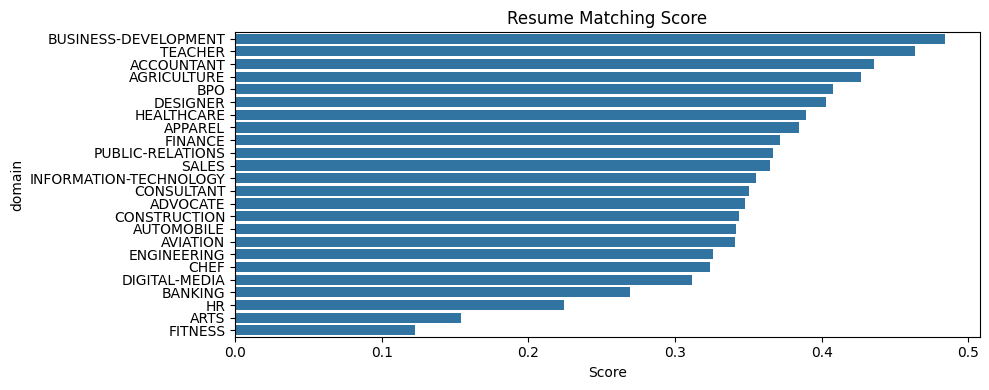

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(x='scores',y='domain', data=final_result_data)
plt.title("Resume Matching Score")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [ ]:
print("POS tags from the top resume: ")
print(resume_df.iloc[top_ranked_resumes[0]]['pos_tags'][:50])

POS tags from the top resume: 
[('SALES', 'PROPN'), ('Executive', 'PROPN'), ('Summary', 'PROPN'), ('Twenty', 'NUM'), ('years', 'NOUN'), ('of', 'ADP'), ('experience', 'NOUN'), ('in', 'ADP'), ('all', 'DET'), ('aspects', 'NOUN'), ('of', 'ADP'), ('sales', 'NOUN'), ('/', 'SYM'), ('marketing', 'NOUN'), ('management', 'NOUN'), ('Focused', 'VERB'), (',', 'PUNCT'), ('goal', 'NOUN'), ('and', 'CCONJ'), ('profit', 'NOUN'), ('-', 'PUNCT'), ('oriented', 'VERB'), ('.', 'PUNCT'), ('Proven', 'ADJ'), ('track', 'NOUN'), ('record', 'NOUN'), ('of', 'ADP'), ('sustainable', 'ADJ'), ('growth', 'NOUN'), ('in', 'ADP'), ('existing', 'VERB'), ('market', 'NOUN'), (',', 'PUNCT'), ('and', 'CCONJ'), ('development', 'NOUN'), ('of', 'ADP'), ('business', 'NOUN'), ('in', 'ADP'), ('new', 'ADJ'), ('markets', 'NOUN'), ('.', 'PUNCT'), ('Effective', 'ADJ'), ('organizational', 'ADJ'), (',', 'PUNCT'), ('communication', 'NOUN'), (',', 'PUNCT'), ('technical', 'ADJ'), (',', 'PUNCT'), ('leadership', 'NOUN'), (',', 'PUNCT')]


In [ ]:
print("Feedback for the top resume: ")
print(resume_df.iloc[top_ranked_resumes[0]]['feedback'])

Feedback for the top resume: 
['All action words used by the applicant are good']


The rankings and properties of the resumes are added to a csv file

In [ ]:
final_result_data.to_csv("Resume_Rankings_Output.csv", index=False)
files.download('Resume_Rankings_Output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>